# **Phisher Fisher**

  The goal of this model is to train a distilBERT model (a smaller and more robust iteration of Google's BERT model) to detect phishing and smishing from a given body of text from common sources such as emails and/or SNS messages.


  This Jupyter Notebook creates and trains the model on detecting phishing. It also contains the metrics of the base model as a control experiment. The goal is to migrate the trained model into a dedicated script, further optimize and train to achieve better scores, and eventually host the model to be used by the main service.

## Downloading the necessary libraries

In [27]:
!pip install torch
!pip install datasets
!pip install tensorflow
!pip install numpy
!pip install keras
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Model Initialization & Data Preprocessing

### Importing the necessary libraries

In [28]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
from datasets import Dataset, load_dataset
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import (DistilBertTokenizer, BertModel,AutoTokenizer, pipeline, AutoModelForSequenceClassification, TrainingArguments,
                          Trainer, DataCollatorWithPadding,DistilBertForSequenceClassification)
from sklearn.metrics import (accuracy_score, recall_score, precision_score, log_loss, roc_auc_score,
                             roc_curve, auc,precision_recall_curve, f1_score)
from sklearn.utils import resample

### Setting up distilBERT and the Tokenizer (necessary for generating input embeddings)

In [29]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

id2label = {0: "benign", 1: "phishing"}
label2id = {"benign": 0, "phishing": 1}

data_collator = DataCollatorWithPadding(tokenizer=distilbert_tokenizer)

distilbert = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Loading the dataset

The dataset I decided to use was the "ealvaradob/phishing-dataset" from HuggingFace. The dataset contains over 10,000 samples of phishing and/or smishing as well as benign messages, all of which are labeled as legitimate or dangerous (supervisted learning).

In [30]:
def import_data(type):
  return load_dataset("ealvaradob/phishing-dataset", type, trust_remote_code=True)['train'].to_pandas()

In [31]:
def split_dataset(df):
  return train_test_split(
    df['text'],
    df['label'],
    stratify=df['label'],
    test_size=0.2,
    random_state=42
  )

In [32]:
texts = import_data("texts").sample(frac=0.5, random_state=42).reset_index(drop=True)

### Splitting the dataset

I split the data from the dataset into X (message) and Y (message type) types, and into training and testing. Since there is not that many samples, I decided to do an 80/20 split between training and testing.

In [33]:
x_train, x_test, y_train, y_test = split_dataset(texts)
print(f"Training samples: {len(x_train)}, Testing samples: {len(x_test)}")

Training samples: 8054, Testing samples: 2014


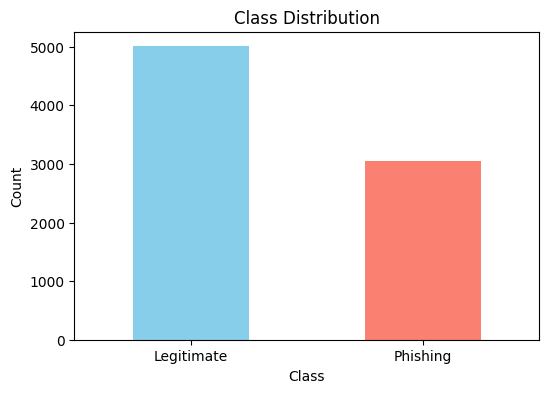

In [ ]:
# Assuming y_train contains the labels (0 for legitimate, 1 for phishing)
label_counts = y_train.value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Phishing'], rotation=0)
plt.show()

### Balancing the dataset

Since there were approximately 2,000 more legitimate samples compared to phishing samples, I decided to undersample the legitimate class to balance the two.

In [34]:
df_train = pd.DataFrame({'text': x_train, 'label': y_train})
# Assuming 'df' is your original DataFrame and has a 'label' column with class labels
# Split the majority and minority classes
df_majority = df_train[df_train['label'] == 0]  # Majority class (Legitimate)
df_minority = df_train[df_train['label'] == 1]  # Minority class (Phishing)

# Check if the minority class is not empty before resampling
if len(df_minority) > 0:
    df_majority_undersampled = resample(df_majority,
                                        replace=False,  # No replacement
                                        n_samples=len(df_minority),  # Match minority class size
                                        random_state=42)
    # Combine the undersampled majority class with the original minority class
    df_balanced = pd.concat([df_majority_undersampled, df_minority])
else:
    print("Minority class is empty, undersampling not performed.")
    df_balanced = df_train  # No undersampling, use the original dataset

# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Now split the data back into X and y
x_train = df_balanced['text']
y_train = df_balanced['label']
print(type(x_train))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


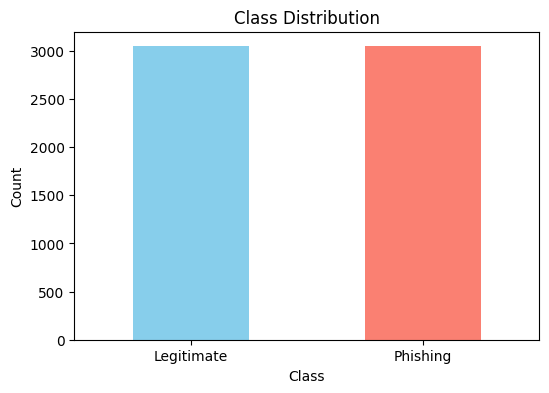

In [ ]:
# Assuming y_train contains the labels (0 for legitimate, 1 for phishing)
label_counts = y_train.value_counts()

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Phishing'], rotation=0)
plt.show()

In [35]:
x_train, x_test, y_train, y_test = split_dataset(texts)
print(f"Training samples: {len(x_train)}, Testing samples: {len(x_test)}")

Training samples: 8054, Testing samples: 2014


In [36]:
print(len(df_balanced))

6096


## Testing the Base Model

An instance of the base distilBERT model from HuggingFace is created, and prints out important metrics after going over the test portion of the dataset.

In [ ]:
# Load the pre-trained pipeline with truncation enabled
base_model = pipeline('text-classification', model='distilbert-base-uncased', return_all_scores=True, truncation=True)

# Predict using the base model
y_pred_base = [
    1 if max(predictions[0], key=lambda x: x['score'])['label'] == 'LABEL_1' else 0
    for predictions in [base_model(text) for text in x_test]
]

# Evaluate the base model
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)

# Print metrics
print("Base Model Metrics:")
print(f"Accuracy: {accuracy_base:.4f}, Precision: {precision_base:.4f}, Recall: {recall_base:.4f}, F1-Score: {f1_base:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Base Model Metrics:
Accuracy: 0.3545, Precision: 0.3532, Recall: 0.8491, F1-Score: 0.4988


### Creating the validation loss graph of the base model

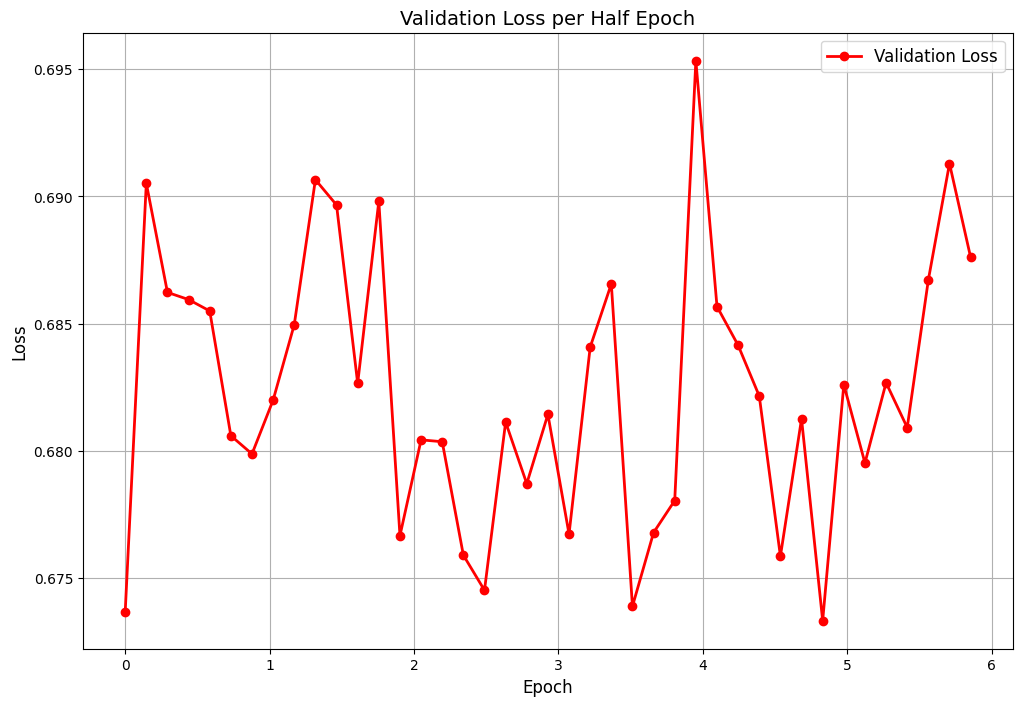

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# Split the test set into smaller batches
batch_size = 50
x_test_batches = [x_test[i:i + batch_size] for i in range(0, len(x_test), batch_size)]
y_test_batches = [y_test[i:i + batch_size] for i in range(0, len(y_test), batch_size)]

# Initialize a list to store validation losses
validation_losses = []

# Calculate the validation loss for each batch
for x_batch, y_batch in zip(x_test_batches, y_test_batches):
    # Get predictions from the base model (probabilities for each class)
    y_pred_probs = np.array([
        [max(predictions[0], key=lambda x: x['score'])['score'],  # Probability for 'phishing'
         1 - max(predictions[0], key=lambda x: x['score'])['score']]  # Probability for 'legitimate'
        for predictions in [base_model(text) for text in x_batch]
    ])

    # Compute log loss for the batch
    batch_loss = log_loss(y_batch, y_pred_probs)
    validation_losses.append(batch_loss)

# Compute batch-to-epoch mapping (assuming even distribution over epochs)
total_batches = len(validation_losses)
half_epoch_step = total_batches / (2 * 3)  # Assuming 3 epochs, divide into half epochs
half_epoch_indices = [i / half_epoch_step for i in range(total_batches)]

# Plot the validation loss per half epoch
plt.figure(figsize=(12, 8))

# Validation loss
plt.plot(half_epoch_indices, validation_losses, label='Validation Loss', color='red', linestyle='-', marker='o', linewidth=2)

# Add labels, title, and grid
plt.title('Validation Loss per Half Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()







## Base Model Training Routine

Here, the base model is trained with the routine below.

Optimization of the training hyperparameters are to be implemented in the future.

In [ ]:
# Tokenize the dataset
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(list(x_train), truncation=True, padding=True, max_length=256, return_tensors="pt")
test_encodings = tokenizer(list(x_test), truncation=True, padding=True, max_length=256, return_tensors="pt")

train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

# Define the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,
    load_best_model_at_end=True
)

# Define Trainer
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


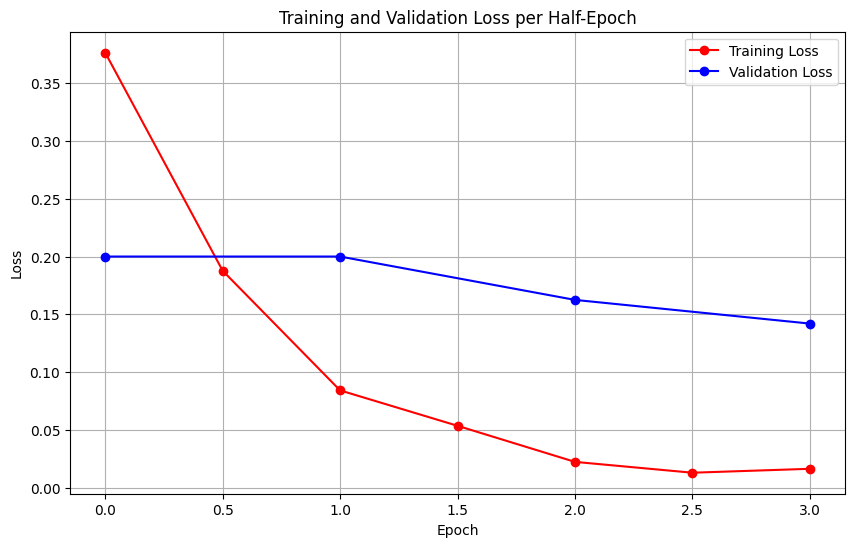

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Retrieve logs
training_logs = trainer.state.log_history

# Extract training and validation losses along with their epochs
train_losses = [(log['epoch'], log['loss']) for log in training_logs if 'loss' in log and 'epoch' in log]
eval_losses = [(log['epoch'], log['eval_loss']) for log in training_logs if 'eval_loss' in log and 'epoch' in log]

# Group training losses by half-epochs
train_loss_per_half_epoch = defaultdict(list)
for epoch, loss in train_losses:
    half_epoch = np.round(epoch * 2) / 2  # Round to nearest 0.5
    train_loss_per_half_epoch[half_epoch].append(loss)

# Compute the average training loss per half-epoch
avg_train_loss_per_half_epoch = {
    half_epoch: sum(losses) / len(losses)
    for half_epoch, losses in sorted(train_loss_per_half_epoch.items())
}

# Prepare validation losses for half-epochs
eval_loss_per_half_epoch = {}
for epoch, loss in eval_losses:
    eval_loss_per_half_epoch[epoch] = loss

# Ensure validation loss starts at epoch 0
if 0.0 not in eval_loss_per_half_epoch:
    first_epoch = min(eval_loss_per_half_epoch.keys())
    eval_loss_per_half_epoch[0.0] = eval_loss_per_half_epoch.get(first_epoch, eval_loss_per_half_epoch.get(first_epoch))

# Carry forward missing validation loss values by filling them
for epoch in sorted(eval_loss_per_half_epoch.keys()):
    if epoch not in eval_loss_per_half_epoch:
        eval_loss_per_half_epoch[epoch] = eval_loss_per_half_epoch.get(epoch - 0.5, None)

# Sorting for consistent plotting
sorted_train_loss = sorted(avg_train_loss_per_half_epoch.items())
sorted_eval_loss = sorted(eval_loss_per_half_epoch.items())

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(
    [x[0] for x in sorted_train_loss],
    [x[1] for x in sorted_train_loss],
    label='Training Loss',
    marker='o',
    color='red',
)
plt.plot(
    [x[0] for x in sorted_eval_loss],
    [x[1] for x in sorted_eval_loss],
    label='Validation Loss',
    marker='o',
    color='blue',
)
plt.title('Training and Validation Loss per Half-Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()



## Metrics for the Trained Model

Below are the metrics of the trained model. The four I decided to display are:

1. **Accuracy**: How efficient model is at determining correct output (benign vs. phishing website)

2. **Precision**: How well the model is at correctly classifying sample to output (samples labeled phishing/all samples classified as phishing)

3. **Recall**: How well the model correctly identifies samples as being class of interest (samples labeled phishing/actual phishing samples)

4. **F1-Score**: Measurement of the performance of model for making predictions

Additionally, a graph depicting the ROC and the AUC are shown below. The ROC displays the relationship between true positive rate & false positive rate, and the AUC is the area under ROC curve (an ideal AUC = 1.0)

In [ ]:
# Evaluate the fine-tuned model
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

accuracy_trained = accuracy_score(test_labels, predicted_labels)
precision_trained = precision_score(test_labels, predicted_labels)
recall_trained = recall_score(test_labels, predicted_labels)
f1_trained = f1_score(test_labels, predicted_labels)

print("Trained Model Metrics:")
print(f"Accuracy: {accuracy_trained:.4f}, Precision: {precision_trained:.4f}, Recall: {recall_trained:.4f}, F1-Score: {f1_trained:.4f}")

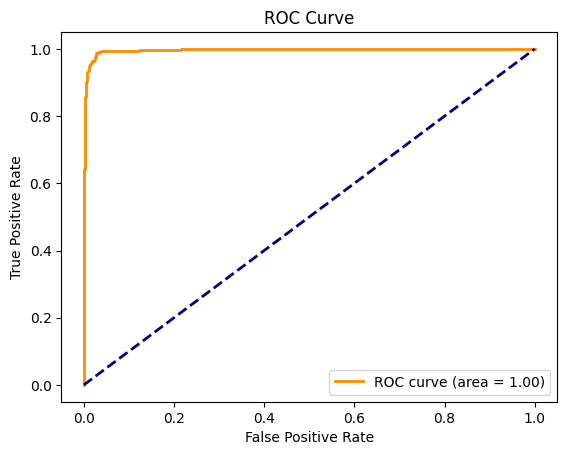

In [ ]:
# Plotting the ROC curve and calculating AUC
y_probs = predictions.predictions[:, 1]
fpr, tpr, _ = roc_curve(test_labels, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Specify the directory where the model and tokenizer will be saved
model_save_path = "saved_model"

# Save the model
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)



In [ ]:
!zip -r saved_model.zip saved_model

In [ ]:
from google.colab import files

# Download the zipped model directory
files.download("saved_model.zip")